<a href="https://colab.research.google.com/github/prisha90/Study-Oriented-Project/blob/main/Glaucoma_Detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from skimage import morphology
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
IMAGES_FOLDER = "/content/drive/MyDrive/SOP (Rajya Lakshmi Ma'am)/Work Document/G1020/Images"
MASK_FOLDER = "/content/drive/MyDrive/SOP (Rajya Lakshmi Ma'am)/Work Document/G1020/Masks"
df = pd.read_csv("/content/drive/MyDrive/SOP (Rajya Lakshmi Ma'am)/Work Document/G1020/G1020.csv")

df = df.sample(n=150, random_state=42)
df = df.head(150)

images = []
labels = []
image_size = (512, 512)

print(f"Total images in dataframe: {len(df)}")

if not os.path.exists(IMAGES_FOLDER):
    print(f"Error: IMAGES_FOLDER not found: {IMAGES_FOLDER}")
else:
    print(f"IMAGES_FOLDER found: {IMAGES_FOLDER}")

missing_images = [img for img in df['imageID'] if not os.path.exists(os.path.join(IMAGES_FOLDER, img))]
if missing_images:
    print(f"Missing images: {len(missing_images)} images not found.")

def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rot_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, rot_matrix, (w, h))
    return cv2.resize(rotated, (512, 512)).reshape(512, 512, 1)

Total images in dataframe: 150
IMAGES_FOLDER found: /content/drive/MyDrive/SOP (Rajya Lakshmi Ma'am)/Work Document/G1020/Images


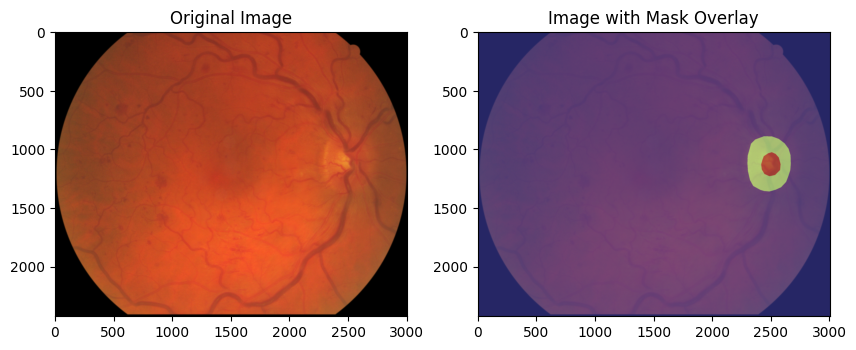

In [ ]:
if not os.path.exists(MASK_FOLDER):
    print(f"Error: MASK_FOLDER not found: {MASK_FOLDER}")

if not os.path.exists(IMAGES_FOLDER):
    print(f"Error: IMAGES_FOLDER not found: {IMAGES_FOLDER}")

if not os.path.exists(MASK_FOLDER):
    print(f"Error: MASK_FOLDER not found: {MASK_FOLDER}")

for img_name in df['imageID']:
    img_path = os.path.join(IMAGES_FOLDER, img_name)

    base_name = os.path.splitext(img_name)[0]
    mask_name = f"{base_name}.png"
    mask_path = os.path.join(MASK_FOLDER, mask_name)

    if not os.path.exists(img_path):
        print(f"Warning: Image not found - {img_path}")
        continue
    if not os.path.exists(mask_path):
        print(f"Warning: Mask not found - {mask_path}")
        continue

    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(image, alpha=0.7)
    plt.imshow(mask, cmap="jet", alpha=0.5)
    plt.title("Image with Mask Overlay")

    plt.show()
    break


Unique values in mask: [0 1 2]


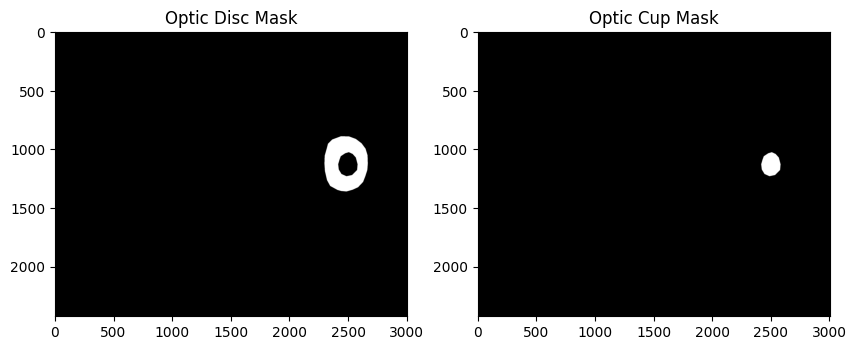

In [ ]:
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
unique_values = np.unique(mask)
print("Unique values in mask:", unique_values)

optic_disc = np.where(mask == 1, 255, 0).astype(np.uint8)
optic_cup = np.where(mask == 2, 255, 0).astype(np.uint8)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(optic_disc, cmap='gray')
plt.title("Optic Disc Mask")

plt.subplot(1, 2, 2)
plt.imshow(optic_cup, cmap='gray')
plt.title("Optic Cup Mask")

plt.show()

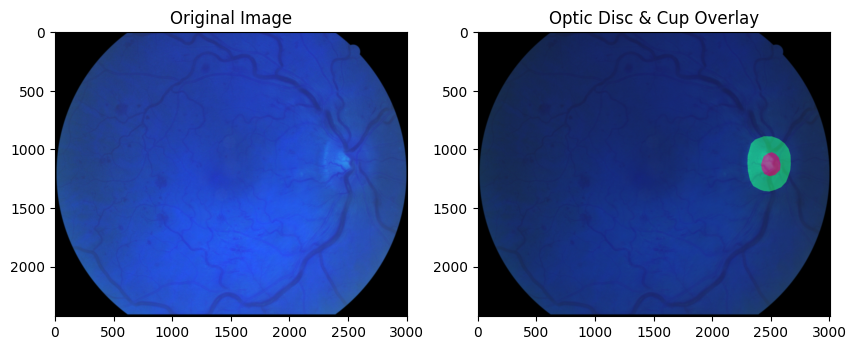

In [ ]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

disc_colored = np.zeros_like(image)
cup_colored = np.zeros_like(image)

disc_colored[optic_disc == 255] = [0, 255, 0]
cup_colored[optic_cup == 255] = [255, 0, 0]

overlay = cv2.addWeighted(image, 0.7, disc_colored, 0.5, 0)
overlay = cv2.addWeighted(overlay, 0.9, cup_colored, 0.5, 0)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Optic Disc & Cup Overlay")

plt.show()